# Supervised binary classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split

In [2]:
file = '../data/classification.xlsx'
D = pd.read_excel(file)

In [3]:
D.dropna(inplace=True)

In [4]:
target = 'dependent variable'
X, target_values = D[[x for x in D.columns if x != target]], D[target].values
encoder = pre.OrdinalEncoder()
y = encoder.fit_transform(target_values.reshape(-1, 1))
S_train, S_test, s_train, s_test = train_test_split(X, y, stratify=X.category, test_size=0.2, random_state=42)

In [5]:
n_cols, c_cols = [], []
for i, x in S_train.dtypes.items():
    if i != 'ad_id' and x in [np.int64, np.float64]:
        n_cols.append(i)
    elif i != 'ad_id':
        c_cols.append(i)
    else:
        pass
N_train, C_train = S_train[n_cols], S_train[c_cols]
N_test, C_test = S_test[n_cols], S_test[c_cols]

In [6]:
scale = True

if scale:
    scaler = pre.MinMaxScaler()
    N_train, N_test = scaler.fit_transform(N_train), scaler.fit_transform(N_test)
else:
    pass

hot = pre.OneHotEncoder(sparse=False)
H_train = hot.fit_transform(C_train)
H_test = hot.fit_transform(C_test)

In [7]:
mode = 'numeric'

if mode == 'numeric':
    Tr, Tx = np.array(N_train), N_test
else:
    Tr, Tx = H_train, H_test

## Binary classifiers
The binary classifiers are specialized classifiers capable of distinguish between a specific class and all the ther classes. For training such a classifier, we need to create a special target.

In [8]:
s_train_0, cat_0_name = (s_train == 0), encoder.categories_[0][0]
s_test_0 = (s_test == 0)

In [9]:
print(cat_0_name)

Non venduto


In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd = SGDClassifier()
sgd.fit(Tr, s_train_0.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd.predict(np.array(Tr[0]).reshape(1, -1))

array([False])

# Evaluate the model performances

## Cross validation

In [13]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
import sklearn.metrics as mx

In [14]:
print(cross_val_score(sgd, Tr, s_train_0.ravel(), cv=3, scoring='accuracy'))
print(cross_val_score(sgd, Tx, s_test_0.ravel(), cv=3, scoring='accuracy'))

[0.84903529 0.84903529 0.84907218]
[0.84564575 0.84564575 0.84564575]


### Limits of accuracy

In [15]:
class No(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((X.shape[0], 1), dtype=bool)

In [16]:
no = No()

In [17]:
print(cross_val_score(no, Tr, s_train_0.ravel(), cv=3, scoring='accuracy'))
print(cross_val_score(no, Tx, s_test_0.ravel(), cv=3, scoring='accuracy'))

[0.84981749 0.84790544 0.84941984]
[0.85468451 0.8390405  0.84321224]


In [20]:
print(len(np.where(y.ravel() == 1)[0]) / len(y))

0.1167172688715322


## Confusion matrix

In [21]:
p_sgd = cross_val_predict(sgd, Tr, s_train_0.ravel(), cv=3)
p_no = cross_val_predict(no, Tr, s_train_0.ravel(), cv=3)

In [22]:
labels = [True, False]

In [23]:
cm_sgd = mx.confusion_matrix(s_train_0, p_sgd, labels=labels)
cm_no = mx.confusion_matrix(s_train_0, p_no, labels=labels)

In [24]:
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


def cm_plot(ax, classes, CM, title, figure):
    im = ax.imshow(CM, interpolation='nearest', cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=0, fontsize=12)
    ax.set_title(title, fontsize=16)
    thresh = CM.max() / 2.
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        ax.text(j, i, CM[i, j], horizontalalignment="center",
                 color="white" if CM[i, j] > thresh else "black", fontsize=12)
    ax.set_ylabel('True label', fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=16)

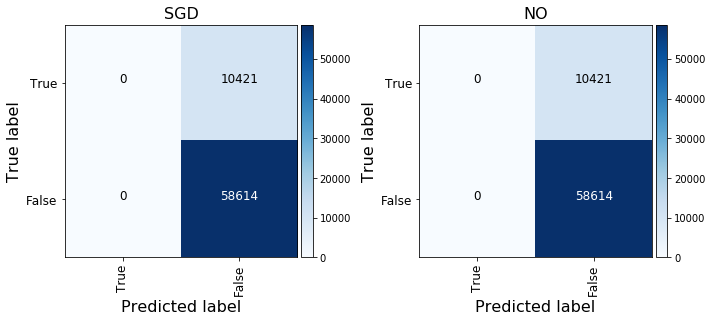

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
cm_plot(ax[0], labels, cm_sgd, 'SGD', fig)
cm_plot(ax[1], labels, cm_no, 'NO', fig)
plt.tight_layout()
plt.show()

In [26]:
print(mx.classification_report(s_train_0, p_sgd))
print(mx.classification_report(s_train_0, p_no))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92     58614
        True       0.00      0.00      0.00     10421

    accuracy                           0.85     69035
   macro avg       0.42      0.50      0.46     69035
weighted avg       0.72      0.85      0.78     69035

              precision    recall  f1-score   support

       False       0.85      1.00      0.92     58614
        True       0.00      0.00      0.00     10421

    accuracy                           0.85     69035
   macro avg       0.42      0.50      0.46     69035
weighted avg       0.72      0.85      0.78     69035



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Exercise: test with categorical values

# Precision and recall tradeoff
Classifiers take binary decisions based on a classification function used in combination with a threshold. We are interested in studing precision and recall with different threshold levels.

In [27]:
sgd.decision_function(N_test)

array([-1.00186941, -1.01032395, -1.02199659, ..., -1.00402467,
       -1.00202018, -1.00412661])

In [28]:
p_scores = cross_val_predict(sgd, N_train, s_train_0.ravel(), cv=3, method='decision_function')

In [29]:
precisions, recalls, thresholds = mx.precision_recall_curve(s_train_0, p_scores)

In [30]:
fpr, tpr, thresholds_roc = mx.roc_curve(s_train_0, p_scores)

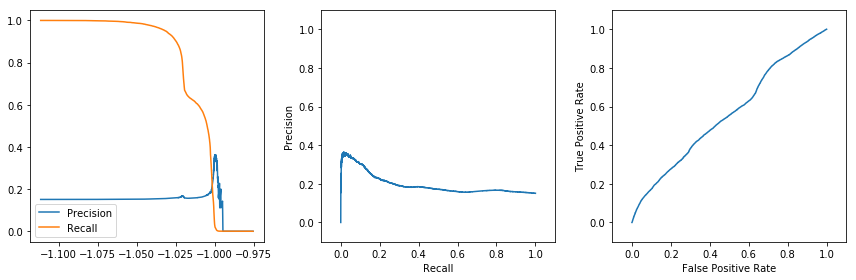

In [31]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax[0].plot(thresholds, precisions[:-1], label='Precision')
ax[0].plot(thresholds, recalls[:-1], label='Recall')
ax[0].legend()
ax[1].plot(recalls[:-1], precisions[:-1])
ax[1].set_xlim((-0.1,1.1))
ax[1].set_ylim((-0.1,1.1))
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[2].plot(fpr[:-1], tpr[:-1])
ax[2].set_xlim((-0.1,1.1))
ax[2].set_ylim((-0.1,1.1))
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

# Compare

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
frs = RandomForestClassifier(n_estimators=20)
frs_probs = cross_val_predict(frs, N_train, s_train_0.ravel(), cv=3, method='predict_proba')
p_frs = cross_val_predict(frs, N_train, s_train_0.ravel(), cv=3)

In [34]:
frs_scores = frs_probs[:,1]

In [35]:
print(mx.classification_report(s_train_0, p_frs))

              precision    recall  f1-score   support

       False       0.86      0.93      0.89     58614
        True       0.24      0.13      0.17     10421

    accuracy                           0.81     69035
   macro avg       0.55      0.53      0.53     69035
weighted avg       0.76      0.81      0.78     69035



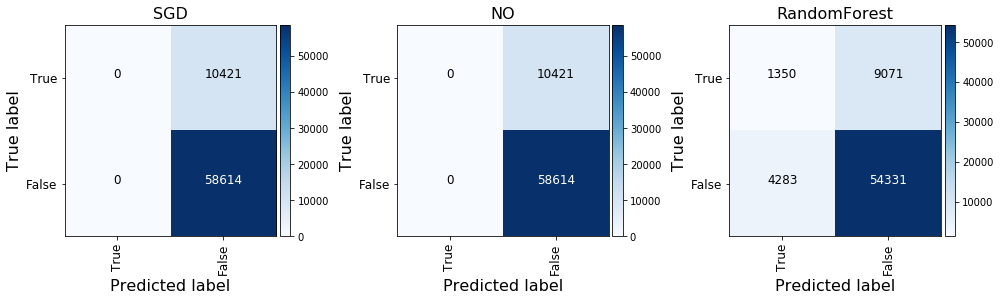

In [36]:
cm_frs = mx.confusion_matrix(s_train_0, p_frs, labels=labels)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 5))
cm_plot(ax[0], labels, cm_sgd, 'SGD', fig)
cm_plot(ax[1], labels, cm_no, 'NO', fig)
cm_plot(ax[2], labels, cm_frs, 'RandomForest', fig)
plt.tight_layout()
plt.show()

In [37]:
fpr_f, tpr_f, thresholds_roc_f = mx.roc_curve(s_train_0, frs_scores)

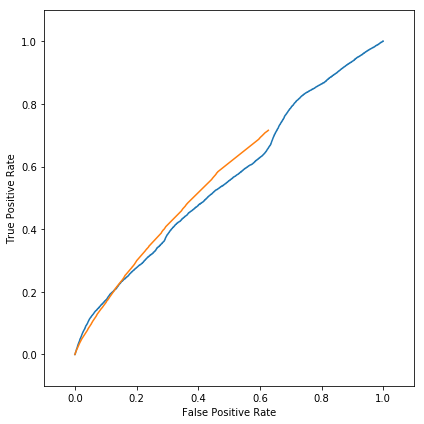

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(fpr[:-1], tpr[:-1])
ax.plot(fpr_f[:-1], tpr_f[:-1])
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

# Combine numeric and categorical

In [39]:
Z_train = np.concatenate((N_train, H_train), axis=1) 

In [40]:
sgd = SGDClassifier()
sgd.fit(Z_train, s_train_0.ravel())
p_all = cross_val_predict(sgd, Z_train, s_train_0.ravel(), cv=3)

In [41]:
print(mx.classification_report(s_train_0.ravel(), p_all))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92     58614
        True       0.00      0.00      0.00     10421

    accuracy                           0.85     69035
   macro avg       0.42      0.50      0.46     69035
weighted avg       0.72      0.85      0.78     69035



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


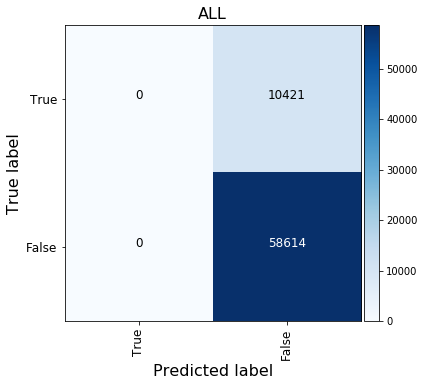

In [42]:
cm_all = mx.confusion_matrix(s_train_0.ravel(), p_all, labels=[True, False])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
cm_plot(ax, labels, cm_all, 'ALL', fig)
plt.tight_layout()
plt.show()